# Cuboid Alignment Rotation Test

Since the overall plan is to align the bounding box of a point cloud with the global coordinate axes, the successful vector alignment rotation method is now transferred onto the cuboid example to solidify its correct working. Below, a cuboid will be defined, rotated and translated, before being both back-translated and back-rotated to its initial position. Accompanying the mathematical operations to complete this, at suiting points visualizations showcasing the procedure will help to visualize the procedure, as I personally find it quite difficult sometimes to understand what is going on without any visual information.

## Imports

In [59]:
# For paths
import os 

# For data processing
import torch
import numpy as np
from torch.utils.data import Dataset
import math
import random

# For 3D visualization
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

## Functions

In [60]:
# Setting the root for this repo
ROOT = os.path.realpath("..")

# Create norm of passed vector
def norm_vec(vector):
    '''
    input:
    - vector: 1x3-array of vector to be normed
    
    return:
    - vector norm
    '''
    return np.linalg.norm(vector)

# Creating unit vector for input vector
def unit_vector(vector):
    '''
    input:
    - vector: 1x3-array of vector to be unitized
    
    output:
    - 1x3-array of unit vector from passed vector
    '''
    return vector / np.linalg.norm(vector)

# Determine coordinates of center of given cuboid corner coordinates
def get_cuboid_center(cuboid_corner_coordinates):
    '''
    Creates 1x3-coordiantes of the cuboid center, based on its corner values.
    '''
    center_x_coord = np.mean(cuboid_corner_coordinates[:,0])
    center_y_coord = np.mean(cuboid_corner_coordinates[:,1])
    center_z_coord = np.mean(cuboid_corner_coordinates[:,2])
    return np.array([center_x_coord, center_y_coord, center_z_coord])

# Function to center cuboid on origin
def center_cuboid (cuboid_coords):
    '''
    inputs:
    - cuboid_coords: 8x3-array of cuboid vertice coordinates
    
    return:
    - centered_cuboid_coords: 8x3-array cuboid vertice coordinates centered on the origin
    '''
    cuboid_center_coords = get_cuboid_center(cuboid_coords)
    centered_cuboid_coords = cuboid_coords - cuboid_center_coords
    return centered_cuboid_coords

# Centering auxiliaries according to cuboid center
def center_with_cuboid(cuboid_coords, coords_to_be_centered):
    '''
    inputs:
    - cuboid_coords: 8x3-array of cuboid vertice coordinates
    - coords_to_be_centered: coords/ vecs to be centered around cuboid center
    
    return:
    - centered_coords: centered coords_to_be_centered
    '''
    cuboid_center_coords = get_cuboid_center(cuboid_coords)
    centered_coords = coords_to_be_centered - cuboid_center_coords
    return centered_coords

# Determine the angle between a vector and a plane normal
def vec_plane_angle(vector, plane_normal):
    '''
    inputs:
    - vector: vector passing through plane
    - plane_normal: 1x3-array of normal vector of respective plane
    
    return:
    - vec_plane_angle: angle between vector and plane in radians
    '''
    vec_plane_angle_argument = np.dot(unit_vector(vector), unit_vector(plane_normal))
    vec_plane_angle = np.arcsin(vec_plane_angle_argument)
    return vec_plane_angle
    

# Retrieve lowest corner fo the cuboid/ bounding box
def get_lowest_corner_coords(cuboid_coords, axis):
    ''' 
    inputs:
    - cuboid_coords: 8x3-array of cuboid vertice coordinates
    - axis: string determining in which direction one wants to retrieve the "lowest corner"
    
    return:
    - lowest_corner_coords: 1x3-array with the coordinates of the "lowest" corner in the specified direction
    '''
    if axis == 'z':
        z_val_lowest_corner = np.min(cuboid_coords[:,2])
        # Correction in the case there are several corners with the same value
        if len(np.where(cuboid_coords == z_val_lowest_corner)) == 1:
            lowest_corner_idx = int(np.where(cuboid_coords == z_val_lowest_corner)[0])
        else:
            lowest_corner_idx = int(np.where(cuboid_coords == z_val_lowest_corner)[0][0])
        lowest_corner_coords = cuboid_coords[lowest_corner_idx]
    elif axis == 'y':
        y_val_lowest_corner = np.min(cuboid_coords[:,1])
        # Correction in the case there are several corners with the same value
        if len(np.where(cuboid_coords == y_val_lowest_corner)) == 1:
            lowest_corner_idx = int(np.where(cuboid_coords == y_val_lowest_corner)[0])
        else:
            lowest_corner_idx = int(np.where(cuboid_coords == y_val_lowest_corner)[0][0])
        lowest_corner_coords = cuboid_coords[lowest_corner_idx]
    elif axis == 'x':
        x_val_lowest_corner = np.min(cuboid_coords[:,0])
        # Correction in the case there are several corners with the same value
        if len(np.where(cuboid_coords == x_val_lowest_corner)) == 1:
            lowest_corner_idx = int(np.where(cuboid_coords == x_val_lowest_corner)[0])
        else:
            lowest_corner_idx = int(np.where(cuboid_coords == x_val_lowest_corner)[0][0])
        lowest_corner_coords = cuboid_coords[lowest_corner_idx]
    return lowest_corner_coords

# Create ascendingly sorted vector distances array
def create_vec_distances(vectors):
    '''
    input:
    - vectors: coordinates of vectors whose distances shall be calculated
    
    return:
    - vector_dists: vector distances
    '''
    vector_dists_list = []
    for i in range(len(vectors)):
        vector_i_dist = norm_vec(vectors[i])
        vector_dists_list.append(vector_i_dist)
    vector_dists = np.array(vector_dists_list)
    return vector_dists

def get_orthonormal_vec_coords(orthonnormal_vec_coords, which):
    '''
    inputs:
    - orthogonal_vec_coords: coordinates of the 3 orthonormal vectors
    - which: string-argument specifying which of the orthonormal vector coordinates to be retrieved
        - longest: x-edge of the bounding box
        - middle: y-edge of the bounding box
        - shortest: z-edge of the bounding box
    
    return:
    - dist_sorted_orthogonal_vec_coords[i]: 1x3-array of corresponding orthonormal vector
    '''
    orthogonal_vec_dists = create_vec_distances(orthonnormal_vec_coords)
    # Sort coordinate list as the distance list 
    dist_sorted_indices = orthogonal_vec_dists.argsort()
    dist_sorted_orthognal_vec_coords = orthonnormal_vec_coords[dist_sorted_indices]
    if which == 'longest':
        return dist_sorted_orthognal_vec_coords[2]
    elif which == 'middle':
        return dist_sorted_orthognal_vec_coords[1]
    elif which == 'shortest':
        return dist_sorted_orthognal_vec_coords[0]
    else:
        print('Argument -which- was specified incorrectly, please correct.')
    
# Translate cuboid by translation vector
def translate_cuboid(cuboid_vertices, translation_vec):
    '''
    inputs:
    - cuboid_vertices: 8x3-matrix with cuboid vertice coordinates
    - translation_vec: vector by which the cuboid/ object should be translated/moved
    
    return:
    - translateed_cuboid_vertices: 8x3-matrix with translated coordinates of cuboid vertices
    '''
    translated_cuboid_vertices = cuboid_vertices + translation_vec
    return translated_cuboid_vertices

# Rotate cuboid by rotation matrix R
# TODO: adjust description and varibale names
def rotate(cuboid_coords, R):
    '''
    inputs:
    - cuboid_coords: 8x3-array/matrix of cuboid vertice coordinates to be rotated
    - R: rotation matrix to be applied for rotation
    
    return:
    - rotated_cuboid_coords: 8x3-array of rotated cuboid vertices coordinates
    '''
    if cuboid_coords.shape == (3,):
        rotated_cuboid_coords = cuboid_coords.T @ R
    else:
        rotated_cuboid_coords_list = []
        for i in range(len(cuboid_coords)):
            rotated_cuboid_vertice_coords = cuboid_coords[i].T @ R
            rotated_cuboid_coords_list.append(rotated_cuboid_vertice_coords)
        rotated_cuboid_coords = np.array(rotated_cuboid_coords_list)
    return rotated_cuboid_coords

# Creation of edge vectors from cuboid corners
def create_edge_vectors(cuboid_corner_coords):
    '''
    Creates the appropriate corner to corner vectors to be displayed, based on corner coordinates.
    
    inputs:
    - cuboid_corner_coords: 8x3-matrix with coordiantes of cuboid vertices
    
    return:
    - edge_vectors: 12x3-matrix with edge vectors
    '''
    edge_vectors = np.array([
        cuboid_corner_coords[1]-cuboid_corner_coords[0], 
        cuboid_corner_coords[3]-cuboid_corner_coords[0],
        cuboid_corner_coords[1]-cuboid_corner_coords[0],
        cuboid_corner_coords[2]-cuboid_corner_coords[1],
        cuboid_corner_coords[5]-cuboid_corner_coords[1],
        cuboid_corner_coords[3]-cuboid_corner_coords[2],
        cuboid_corner_coords[6]-cuboid_corner_coords[2],
        cuboid_corner_coords[7]-cuboid_corner_coords[3],
        cuboid_corner_coords[5]-cuboid_corner_coords[4],
        cuboid_corner_coords[7]-cuboid_corner_coords[4],
        cuboid_corner_coords[6]-cuboid_corner_coords[5],
        cuboid_corner_coords[7]-cuboid_corner_coords[6]
        ])
    return np.squeeze(edge_vectors)

# Create rotation matrix based on angle and axis
def create_rot_mat(theta, axis):
    '''
    Creates a 3x3-Rotation matrix based on rotation angle (theta) and string specification of the rotation-axis.
    
    inputs:
    - theta: rotation angle in radians
    - axis:  axis by which the rotation takes place
    
    returns:
    - rot_mat: rotation matrix for the specific rotation requested
    '''
    theta = math.radians(theta)
    if axis == 'x':
        rot_mat = [
            [1,     0,              0             ],
            [0,     np.cos(theta),  -np.sin(theta)],
            [0,     np.sin(theta),  np.cos(theta) ]
        ]
    elif axis == 'y':
        rot_mat = [
            [np.cos(theta),     0,      np.sin(theta)],
            [0,                 1,      0            ],
            [-np.sin(theta),    0,      np.cos(theta)]
        ]
    elif axis == 'z':
        rot_mat = [
            [np.cos(theta),     -np.sin(theta),     0],
            [np.sin(theta),     np.cos(theta),      0],
            [0,                 0,                  1]
        ]
    else:
        rot_mat = 0
        print("Rotation axis was not defined properly")
    return np.array(rot_mat)


# Form single rotation matrix from Rx, Ry and Rz
def combine_rot_mats(Rx, Ry, Rz):
    '''
    Construction of single 3x3-Rotation matrix based on the three individual Rotation matrices around each axis.
    
    input:
    - Rx:   Rotation matrix for rotation around x-axis
    - Ry:   Rotation matrix for rotation around y-axis
    - Rz:   Rotation matrix for rotation around z-axis
    
    returns:
    - total_rot_mat: combined/ matrix-multiplied rotation matrix describing all three rotations
    '''
    # Conversion to arrays for matrix multiplication
    if (isinstance(Rx, np.ndarray)) or (isinstance(Rx, np.ndarray)) or (isinstance(Rx, np.ndarray)):
        Rx, Ry, Rz = np.array(Rx), np.array(Ry), np.array(Rz)
    total_rot_mat = np.matmul(np.matmul(Rx, Ry), Rz)
    return total_rot_mat

# Determining the rotation matrix based on axis of rotation and angle
def create_axis_angle_rot_mat(axis_unit_vec, angle):
    '''
    Creates a 3x3-Rotation matrix based on given axis of rotation and rotation angle.
    
    inputs:
    - axis_unit_vec:    unit vector of rotation axis | 1x3 np.ndarray
    - angle:            rotation angle by which object should be rotated aorund the axis_unit_vec
    
    returns:
    - R:    rotation matrix describing rotation by angle around axis_unit_vec
    '''
    R = [
        [   np.cos(angle) + axis_unit_vec[0]**2*(1-np.cos(angle)),                                      #0,0
            axis_unit_vec[0]*axis_unit_vec[1]*(1-np.cos(angle)) - axis_unit_vec[2]*np.sin(angle),       #0,1
            axis_unit_vec[0]*axis_unit_vec[2]*(1-np.cos(angle)) + axis_unit_vec[1]*np.sin(angle)    ],  #0,2
        
        [   axis_unit_vec[1]*axis_unit_vec[0]*(1-np.cos(angle)) + axis_unit_vec[2]*np.sin(angle),       #1,0
            np.cos(angle) + axis_unit_vec[1]**2*(1-np.cos(angle)),                                      #1,1
            axis_unit_vec[1]*axis_unit_vec[2]*(1-np.cos(angle)) - axis_unit_vec[0]*np.sin(angle)    ],  #1,2
        
        [   axis_unit_vec[2]*axis_unit_vec[0]*(1-np.cos(angle)) - axis_unit_vec[1]*np.sin(angle),       #2,0
            axis_unit_vec[2]*axis_unit_vec[1]*(1-np.cos(angle)) + axis_unit_vec[0]*np.sin(angle),       #2,1
            np.cos(angle) + axis_unit_vec[2]**2*(1-np.cos(angle))                                   ]   #2,2
    ]
    return np.array(R)

# Plotting funtion for cuboid(s)
def plot_cuboids(title,
                 cuboids, 
                 colors, 
                 orthonormal_vec_display=False, 
                 orthonormal_vecs_start=None,
                 orthonormal_vecs_coords=None,
                 orthonormal_vec_color='orange',
                 plot_origin=True):
    
    '''
    Plotting function to plot several cuboids, the origin, potentially 1 (!) trio of orthonormal vectors in different colors
    
    inputs:
    - title: string for the title of the plot
    - cuboids: list of 8x3-arrays with cuboid vertice coordinates
    - colors: list of colors according to which cuboids shall be plotted
    - orthonormal_vec_display: boolean determining whether orthonormal vector shall be plotted -> default=False
    - orthonormal_vecs_start: 1x3-array with coordinates of point where orthonormal vectors will start
    - orthonormal_vecs_coords: 3x3-array of orthonormal vector coordinates/ directions
    - orthonormal_vec_color: string specifying color of the orthonormal vectors to be plotted
    - plot_origin: boolean determining whether the oprigin shall be plotted -> default=True
    
    return:
    - plot/ figure of cuboids to be plotted and shown
    '''
    # Check if amount of colors and cuboids to plot match 
    if len(cuboids) != len(colors):
        print("Amount of cuboids and colors to be plotted do not match, please correct.")
    
    # Creation of figure and subplot for plotting
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Setting title
    plt.title(str(title))
    
    # Origin - as black Plus/ Cross
    if plot_origin:
        ax.scatter(xs=0,
            ys=0,
            zs=0,
            marker='+', 
            c='black', 
            s=200)
        
    # Axes - as quivers in grey
    x_start = [-8, 0, 0]
    y_start = [0, -8, 0]
    z_start = [0, 0, -8]
    axes_start = np.vstack((x_start, 
                            y_start, 
                            z_start))
    x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
    x_vec = [16, 0, 0]
    y_vec = [0, 16, 0]
    z_vec = [0, 0, 16]
    axes_vec = np.vstack((x_vec, 
                        y_vec, 
                        z_vec))
    u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
    ax.quiver(x, y, z, u, v, w,
            arrow_length_ratio=0.05, 
            color='grey')
    
    # Defining corner connections for edges
    edges = [
        [0, 1],     #0
        [0, 3],     #1
        [0, 4],     #2
        [1, 2],     #3
        [1, 5],     #4
        [2, 3],     #5
        [2, 6],     #6
        [3, 7],     #7
        [4, 5],     #8
        [4, 7],     #9
        [5, 6],     #10
        [6, 7]      #11
    ]
    
    # Painting orthonormal corner vectors if set to True
    if orthonormal_vec_display:
        if (orthonormal_vecs_start is None) or (orthonormal_vecs_coords is None):
            print('The starting point or the vector values for the orthonormal vector trio is empty or not correct, please check.')
        else:
            x, y, z = [orthonormal_vecs_start[0]] * 3, \
                      [orthonormal_vecs_start[1]] * 3, \
                      [orthonormal_vecs_start[2]] * 3, 
            u, v, w = orthonormal_vecs_coords[:,0], \
                      orthonormal_vecs_coords[:,1], \
                      orthonormal_vecs_coords[:,2]
            ax.quiver(x, y, z, u, v, w,
                     arrow_length_ratio=0.075, 
                     color=str(orthonormal_vec_color))
        
    # Painting edges of cuboid(s)
    for i in range(len(cuboids)):
        cuboid_vertices_to_plot = cuboids[i]
        for edge in edges:
            for edge in edges:
                x = [cuboid_vertices_to_plot[edge[0]][0], cuboid_vertices_to_plot[edge[1]][0]]
                y = [cuboid_vertices_to_plot[edge[0]][1], cuboid_vertices_to_plot[edge[1]][1]]
                z = [cuboid_vertices_to_plot[edge[0]][2], cuboid_vertices_to_plot[edge[1]][2]]
                ax.plot(x, y, z, f'{str(colors[i])}-')           
    
    # Limits for display
    ax.set_xlim([-8, 8])
    ax.set_ylim([-8, 8])
    ax.set_zlim([-8, 8])

    # Axes Description
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()
    
# Find R for aligning vec1 with vec2
def rot_mat_from_vecs(vec1, vec2):
    '''
    Find rotation matrix aligning vec1 with vec 2 (based in Rodrigues' rotation formula)
    
    inputs:
    - vec1: vector to be aligned | 1x3-array
    - vec2: vector to be aligned with | 1x3-array
    
    return:
    - rot_mat: rotation matrix rotating vec1 onto vec2
    '''
    vec1_uv, vec2_uv = unit_vector(vec1).reshape(3), unit_vector(vec2).reshape(3)
    v = np.cross(vec1_uv, vec2_uv)
    c = np.dot(vec1_uv, vec2_uv)
    s = norm_vec(v)
    kmat = np.array([[0, -v[2], v[1]], 
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])
    rot_mat = np.eye(3) + kmat + kmat.dot(kmat) * ((1-c) / (s**2))
    return rot_mat

# Rotate coordinates with rotation amtrix for axis alignment
def rotate_coords_onto_axis(coords, R):
    ''' 
    
    '''
    if coords.shape == (3,):
        coords_rot = R.dot(coords)
    coords_rot_list = []
    for i in range(len(coords)):
        coords_i_rot = R.dot(coords[i])
        coords_rot_list.append(coords_i_rot)
    coords_rot = np.array(coords_rot_list)
    return coords_rot

# Cuboid to be aligned

The main problem to be solved by this technique is the alignment of the point clouds, so that they are all centered at the same position, in order to prevent any positional bias for the data to be introduced to the model. Therefore, the test in this notebook involves the back rotation and alignment of a cuboid with the x-, y- and z-axis. For a start a general cuboid is defined below, which will then be rotated and translated to an arbitrary position. For a start the rotation of the cuboid and its translation can be set by in the cell below, afterwards, no other manual intervention should be needed. But anyone taking a look at this should be able to set both rotation and translation to whatever values they desire. 

### Definition of rotation and translation parameters

In [61]:
# Definition of rotation angles
theta1, theta2, theta3 = 10, 20, 20

# Definition of translation vector
translation_vec = np.array([3, 3, 3])

### Cuboid definition

In [62]:
# Cuboid vertices definition with numbered index for edges as comments to the right
cuboid_coords = np.array([
    [-4, 2, -0.5],     #0
    [4, 2, -0.5],      #1
    [4, -2, -0.5],     #2
    [-4, -2, -0.5],    #3
    [-4, 2, 0.5],      #4
    [4, 2, 0.5],       #5
    [4, -2, 0.5],      #6
    [-4, -2, 0.5]      #7
])

### Cuboid rotation and translation

In [63]:
# Creation of rotation matrices for out rotation
Rx = create_rot_mat(theta1, 'x')
Ry = create_rot_mat(theta2, 'y')
Rz = create_rot_mat(theta3, 'z')
R = combine_rot_mats(Rx, Ry, Rz)

# Rotating original cuboid
cuboid_coords_rot = rotate(cuboid_coords, R)

# Translation of rotated cube
cuboid_coords_rot_tran = translate_cuboid(cuboid_coords_rot, translation_vec)

### Visualization of original, rotated and translated cuboid

In order to get a good picture below you can find the visualization of the original cuboid (in blue), the rotated cuboid (in red) and lastly the translated cuboid in green. The green cuboid is the cuboid, which will be aligned within this notebook.

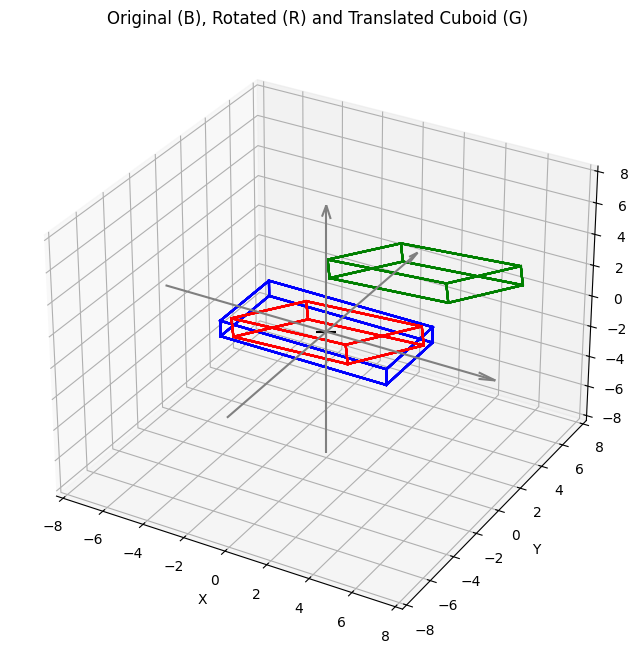

In [64]:
plot_cuboids(
    title='Original (B), Rotated (R) and Translated Cuboid (G)',
    cuboids=[cuboid_coords, cuboid_coords_rot, cuboid_coords_rot_tran],
    colors=['b', 'r', 'g']
)

# Backtranslation of cuboid

As a start the rotated and translated cuboid will be translated back to the origin, as the general/ usual rotations based on rotation matrices revolves around the origin or the axes that meet there. Hence, this step was one of the first undertaken, but with the strategy implemented in this notebook the back translation to the origin does not seem necessary, nevertheless for visualization purposes it has been done, as it is easier to see the alignment of the cuboid at the origin than it is at random places in the global 3D coordinate system. 

In [65]:
cuboid_coords_rot_centered = center_cuboid(cuboid_coords_rot_tran)

# Determination of orthonormal vector trio of cuboid

As a base for rotating the cuboid back to the origin, there are some assunmptions made to the bounding box of point clouds. The assumtpions are as follows:
- the bounding box (cuboid) is not a perfect cube
- the sides of the bounding box are all of non-equal length
- a corner of the bounding box displays three orthonormal vectors meeting <br>
<br>
As it seems natural to align a cuboid (a bounding box around a point cloud displaying a wall-like structure) in such a manner, that the structure does face "upwards" (meaning the shortest edge is aligne with the z-axis). In this way a grid for the blocking can be foremed only based on the x-axis and y-axis valkues, keeping the third coordinate constant as the average. Therefore, the strategy to align a bounding box with the global coordinate system is to align the longest edge of the bounding box with the x-axis, the middle edge with the y-axis and the shortest edge with the z-axis. For the cuboid to be aligned with the axis, essentially the respective edge vectors can be mapped onto the respective axes they should be aligned with. As aligning two axes leads to automatic alignment of the third only two rotations based on vector projection are required.

In [66]:
# retrieving lowest corner in z-direction
lowest_corner_coords = get_lowest_corner_coords(cuboid_coords_rot_centered, axis='z')

# TODO: Maybe make a function for this
# Construction of vectors to all other corners
lowest_corner_to_corner_vectors_list = []
for i in range(len(cuboid_coords_rot_centered)):
    lowest_corner_to_corner_i_vec = cuboid_coords_rot_centered[i] - lowest_corner_coords
    # Skip vector to the corner itself
    if (lowest_corner_to_corner_i_vec == np.array([0, 0, 0])).all():
        continue
    lowest_corner_to_corner_vectors_list.append(lowest_corner_to_corner_i_vec)
lowest_corner_to_corner_vectors = np.array(lowest_corner_to_corner_vectors_list)

# Determining the distances of all the vectors to pick the shortest one -> z-edge
lowest_corner_to_corner_dists = create_vec_distances(lowest_corner_to_corner_vectors)
shortest_lowest_corner_to_corner_dist = np.min(lowest_corner_to_corner_dists)
shortest_lowest_corner_to_corner_vector_idx = int(
    np.where(shortest_lowest_corner_to_corner_dist == shortest_lowest_corner_to_corner_dist)[0]
)
shortest_lowest_corner_to_corner_vector_coords = lowest_corner_to_corner_vectors[shortest_lowest_corner_to_corner_vector_idx]

# Calculating dot-product to check for angle with shortest vector 
orthonormal_vec_coords_list = []
for i in range(len(lowest_corner_to_corner_vectors)):
    dot_product_result = np.dot(
        shortest_lowest_corner_to_corner_vector_coords, 
        lowest_corner_to_corner_vectors[i]
    )
    if dot_product_result <= 0.0001:
        orthonormal_vec_coords_list.append(lowest_corner_to_corner_vectors[i])
orthonormal_vec_coords = np.array(orthonormal_vec_coords_list)

# Filtering out orthogonal lowest corner to corner vector which shouldnt be aligned with axes
orthonormal_corner_vector_distances = create_vec_distances(orthonormal_vec_coords_list)
longest_orthogonal_vec_dist = np.max(orthonormal_corner_vector_distances)
longest_orthogonal_vec_idx =  int(
    np.where(orthonormal_corner_vector_distances == longest_orthogonal_vec_dist)[0]
)
# Deletion of said vector and appending shortest vector
del orthonormal_vec_coords_list[longest_orthogonal_vec_idx]
orthonormal_vec_coords_list.append(shortest_lowest_corner_to_corner_vector_coords)
orthonormal_vec_coords = np.array(orthonormal_vec_coords_list)

/var/folders/g7/q6dyp4d97mdcwhfdvx5rp9n40000gn/T/ipykernel_53782/3960805880.py:19: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  np.where(shortest_lowest_corner_to_corner_dist == shortest_lowest_corner_to_corner_dist)[0]
/var/folders/g7/q6dyp4d97mdcwhfdvx5rp9n40000gn/T/ipykernel_53782/3960805880.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shortest_lowest_corner_to_corner_vector_idx = int(
/var/folders/g7/q6dyp4d97mdcwhfdvx5rp9n40000gn/T/ipykernel_53782/3960805880.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a sin

### Visualization of cuboid to be aligned with orthonormal vectors

In order to make sure the corret vector were determined, below the back-translated and centered (center of cuboid lies on origin) cuboid is shown in blue, with the respective edge vectors marked in orange.

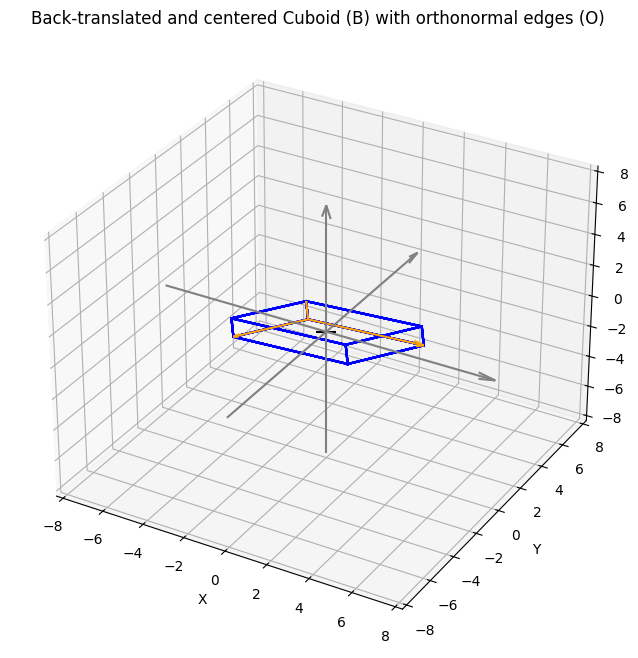

In [67]:
plot_cuboids(
    title='Back-translated and centered Cuboid (B) with orthonormal edges (O)',
    cuboids=[cuboid_coords_rot_centered],
    colors=['b'],
    orthonormal_vec_display=True, 
    orthonormal_vecs_start=lowest_corner_coords,
    orthonormal_vecs_coords=orthonormal_vec_coords, 
    orthonormal_vec_color='orange'
)

# Backrotation/ Alignment of cuboid

Now the fun begins! As previously mentioned the back rotation of a cuboid with this technique requires two rotations, the first alignment/ rotation will lead to the alignment of the shortest edge of the cuboid (bounding box) to be aligned with the z-axis, while the second rotation will lead to the alingment of the longest edge of the cuboid to be aligned with the x-axis.

## First backrotation/ alignment

With the first backrotation the goal is to align the shortest edge of the cuboid with the z-edge of the bounding box.

In [68]:
# First Rotation / Alignment ##############################################################
# Pulling coordinates of shortest orthonormal vector
z_edge = get_orthonormal_vec_coords(orthonormal_vec_coords, 'shortest')
# Retrieving rotation matrix
R_rot1 = rot_mat_from_vecs(z_edge, np.array([0, 0, 1]))
# Rotating the cuboid
cuboid_coords_back_rot_1 = rotate_coords_onto_axis(cuboid_coords_rot_centered, R_rot1)
orthonormal_vec_coords_back_rot_1 = rotate_coords_onto_axis(orthonormal_vec_coords, R_rot1)

# cuboid_coords_back_rot1_list = [] 
# for i in range(len(cuboid_coords_rot_centered)):
#     cuboid_vertice_i_coord_back_rot1 = R.dot(cuboid_coords_rot_centered[i])
#     cuboid_coords_back_rot1_list.append(cuboid_vertice_i_coord_back_rot1)
# cuboid_coords_back_rot1 = np.array(cuboid_coords_back_rot1_list)
    


# # Rotating cuboid, orthonormal vectors and lowest corner
# cuboid_coords_back_rot_1 = rotate(cuboid_coords_rot_centered, R_rot1)
# orthonormal_vec_coords_back_rot_1 = rotate(orthonormal_vec_coords, R_rot1)
# lowest_corner_coords_back_rot_1 = rotate(lowest_corner_coords, R_rot1)
# TODO: Maybe get rid of centering here and do it once as last step -> test!
# Centering rotated cuboid and auxiliaries
# centered_cuboid_coords_back_rot_1 = center_cuboid(cuboid_coords_back_rot_1)
# centered_orthonormal_vec_coords_back_rot_1 = center_with_cuboid(cuboid_coords_back_rot_1, 
#                                                                 orthonormal_vec_coords_back_rot_1)
# centered_lowest_corner_coords_back_rot_1 = center_with_cuboid(cuboid_coords_back_rot_1, 
#                                                               lowest_corner_coords_back_rot_1)


### Visualization of first backrotation / aligment

The first rotation/ alignmetn should lead the cuboid to be parallel to the xy-plane. The visualizatino fo the first rotation can be found below.

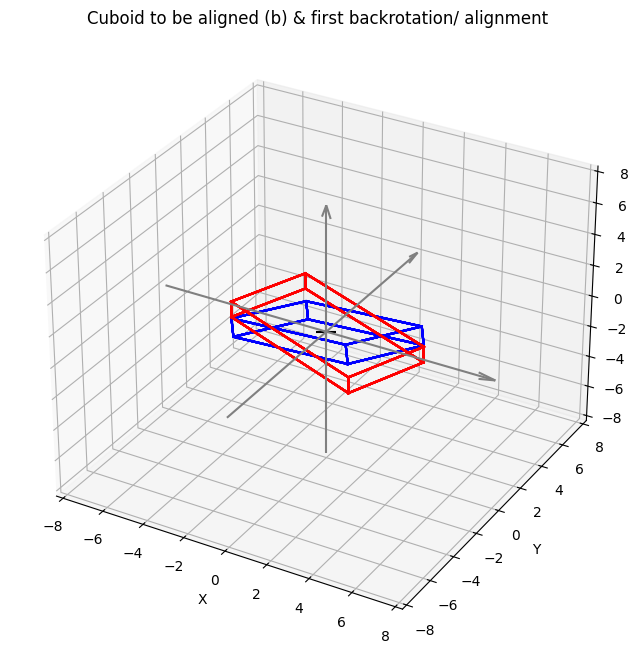

In [69]:
plot_cuboids(
    title='Cuboid to be aligned (b) & first backrotation/ alignment',
    cuboids=[cuboid_coords_rot_centered, cuboid_coords_back_rot_1],
    colors=['b', 'r']
)

## Second backrotation / alignment

After aligning the cuboid with the z-axis and guaranteeing it to be parallel to the xy-plane, there is only one more rotation needed to align the cuboid with the global coordinate axes. Therefore, the second/ next/ last rotation will be aligning the longest edge ofthe cuboid with the x-axis.

In [70]:
# Second Rotation / Alignment ##############################################################
# Pulling coordinates of longest orthonormal vector
x_edge = get_orthonormal_vec_coords(orthonormal_vec_coords_back_rot_1, 'longest')
# Creating rotation matrix for alignment
R_rot2 = rot_mat_from_vecs(x_edge, np.array([1, 0, 0]))
# Rotating
cuboid_coords_back_rot_2 = rotate_coords_onto_axis(cuboid_coords_back_rot_1, R_rot2)

# Rotating
# cuboid_coords_back_rot_2 = rotate(centered_cuboid_coords_back_rot_1, R_rot2)
# orthonormal_vec_coords_back_rot_2 = rotate(centered_orthonormal_vec_coords_back_rot_1, R_rot2)
# lowest_corner_coords_back_rot_2 = rotate(centered_lowest_corner_coords_back_rot_1, R_rot2)
# # Centering
# centered_cuboid_coords_back_rot_2 = center_cuboid(cuboid_coords_back_rot_2)
# centered_orthonormal_vec_coords_back_rot_2 = center_with_cuboid(cuboid_coords_back_rot_2, 
#                                                                 orthonormal_vec_coords_back_rot_2)
# centered_lowest_corner_coords_back_rot_2 = center_with_cuboid(cuboid_coords_back_rot_2, 
#                                                               lowest_corner_coords_back_rot_2)

### Visualization of the second backrotation/ alignment

Et voilà! The cuboid should be aligned with the global coordinate system after the second rotation. The outcome of the second rotation with respect to the outcome of the previous rotaiton can be seen below.

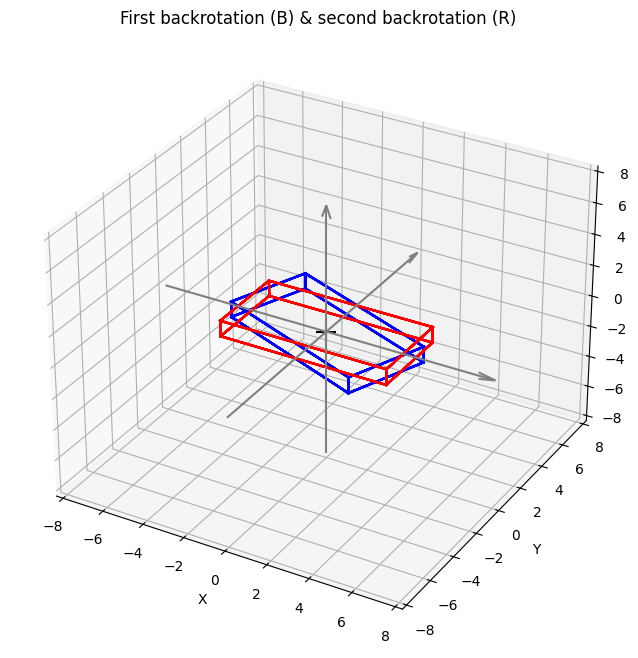

In [71]:
plot_cuboids(
    title='First backrotation (B) & second backrotation (R)',
    cuboids=[cuboid_coords_back_rot_1, cuboid_coords_back_rot_2],
    colors=['b', 'r'],
)

## Final alignment and original

In order, visualize the correct back rotation, the original cuboid, as defined in the beginning, is displayed alongside the outcome of the backrotated cuboid below. While the original cuboid will be painted in blue, the backrotated will be painted in red, hence the blue should not be visible.

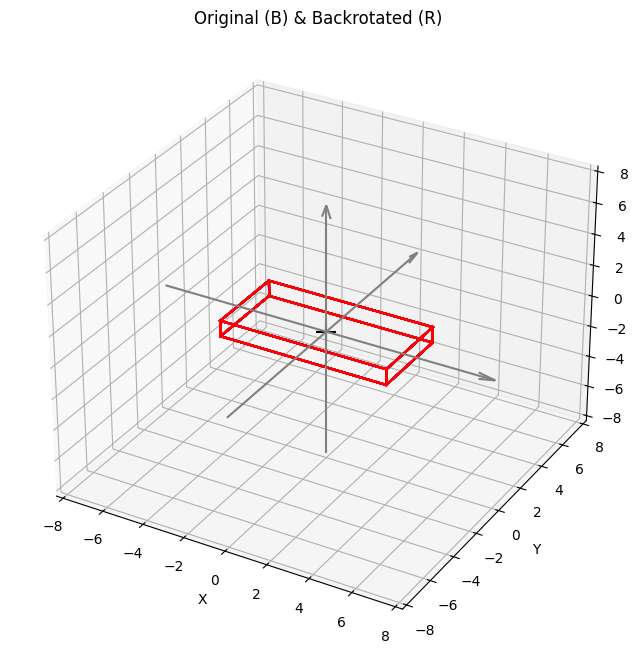

In [72]:
plot_cuboids(
    title='Original (B) & Backrotated (R)',
    cuboids=[cuboid_coords, cuboid_coords_back_rot_2],
    colors=['b', 'r'],
)

In order to drive home the point, the numerical equality of both coordinate sets will be checked below, before arriving at the conclusion.

In [78]:
print(cuboid_coords == cuboid_coords_back_rot_2)

[[False False False]
 [ True False False]
 [False  True False]
 [False False False]
 [False False False]
 [False  True False]
 [False False False]
 [ True False False]]


HAHA! You thought you had me there! I was equally surprised seeing it the first time, but below you can find the values printed out to check for yourself.

In [74]:
print(cuboid_coords)

[[-4.   2.  -0.5]
 [ 4.   2.  -0.5]
 [ 4.  -2.  -0.5]
 [-4.  -2.  -0.5]
 [-4.   2.   0.5]
 [ 4.   2.   0.5]
 [ 4.  -2.   0.5]
 [-4.  -2.   0.5]]


In [75]:
print(cuboid_coords_back_rot_2)

[[-4.   2.  -0.5]
 [ 4.   2.  -0.5]
 [ 4.  -2.  -0.5]
 [-4.  -2.  -0.5]
 [-4.   2.   0.5]
 [ 4.   2.   0.5]
 [ 4.  -2.   0.5]
 [-4.  -2.   0.5]]


Turns out, the rotation as performed does not lead to completely identical results, as they differ at the 15th position after the comma... Hence, I concllude this as successful!

In [79]:
print(cuboid_coords[0][0])
print(cuboid_coords_back_rot_2[0][0])

-4.0
-4.000000000000002


# Conclusion

Finally, after quite some testing and searching and visiting the old basic three-dimensional geometric mathematics, the backrotation of a cuboid - or in our case bounding box - can be accomplished. With this technique, I believe the entire dataset can be handled, after investigating any edges cases for the rotation, such as initial parallelism of egdes with axes. Therefore, as a next step this technique will be tested on a selected sample of the point cloud dataset to assure the correctness and workings of the alingment, prior to the actual blocking taking place. 